In [1]:
import sklearn
import pandas as pd
import numpy as np
import math
import warnings
# plotting
import seaborn as sns
from matplotlib import pyplot 
import matplotlib.pyplot as plt
sns.set(context='paper', style='whitegrid', rc={'figure.facecolor':'white'}, font_scale=1.2)

# preproc
from scipy.stats import zscore

from sklearn.experimental import enable_iterative_imputer 
from sklearn.impute import IterativeImputer
from sklearn.impute import KNNImputer

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.compose import ColumnTransformer, make_column_transformer

# modeling
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

# grid search CV for model tuning
from sklearn.model_selection import train_test_split, GridSearchCV, RepeatedStratifiedKFold

# metrics for classification
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import recall_score, precision_score, average_precision_score
from sklearn.metrics import accuracy_score, f1_score, brier_score_loss
from sklearn.metrics import classification_report, confusion_matrix 
from sklearn.metrics import make_scorer

# post-processing 
from sklearn.calibration import calibration_curve
from sklearn.calibration import CalibratedClassifierCV, _CalibratedClassifier


# statistical reporting
import statsmodels.api as sm

# import custom functions from my package
import sys
import os
sys.path.append("../")
from mcc_metastasis import modeling 
from mcc_metastasis import custom_plots
from mcc_metastasis import data_cleaning

RANDOM = 0
figure_path = "../figures/TNM_outcome/NCDB_5_features/"

## 1. Prep data

- load data 

In [2]:
# OPEN DATA 
df = pd.read_csv("../data/cleaned/NCDB_cleaned_all_cases.csv")
## select relevant variables: removed sex and tumor site
df = df [[ 'tumor_lymphocytes', 'lymph_vasc_invasion', 'TNM_positive']]

# clean up 
df['TNM_negative'] = df.TNM_positive.replace({0:1, 1:0})
df = df.drop(columns = 'TNM_positive')
df.TNM_negative.value_counts()


1.0    5043
0.0     713
Name: TNM_negative, dtype: int64

### data version 1: drop all cases with missing data

In [3]:
df_complete = df.dropna(axis = 0)
df_complete.shape

(1250, 3)

### data version 2: retain samples using imputation


In [4]:
data_cleaning.get_missingness_table(df)

Missingness of features


,index,Missing
0,tumor_lymphocytes,12260
1,lymph_vasc_invasion,10026
2,TNM_negative,9192


In [5]:
# what did i remove? sex, tumor site, 
df2 = df[(df.TNM_negative.isnull() == False) &
       (df.tumor_lymphocytes.isnull() == False)]

# how many would we need to impute?
data_cleaning.get_missingness_table(df2)

Missingness of features


,index,Missing
0,tumor_lymphocytes,0
1,lymph_vasc_invasion,385
2,TNM_negative,0


### Impute missing data 
- imputing lymph vasc invasion, tumor_size
- don't want to include outcome in imputation process...

In [6]:
outcome = df2['TNM_negative'].reset_index(drop = True)
features = df2.drop(columns =[ 'TNM_negative'])
imputer = KNNImputer()
imputed_features = pd.DataFrame(imputer.fit_transform(features), columns = features.columns)
imputed_df = pd.concat([imputed_features, outcome], axis = 1)
imputed_df.shape

(1635, 3)

In [7]:
# checkL has non-binary values
imputed_features.lymph_vasc_invasion.value_counts()

0.0    1216
1.0     357
0.2      62
Name: lymph_vasc_invasion, dtype: int64

### Define cross validation
- split data into train-val and hold-out test sets 
- stratified CV folds, 3 folds repeated 5x with random sampling

In [8]:
 # make cross val folds - 
CV_folds =  RepeatedStratifiedKFold(n_splits = 3, 
                                    n_repeats =  5,  
                                    random_state = 0)
 

### Define Models
- instead of tuning the model itself, just comparing calibration metods

In [11]:
LR_model = LogisticRegression(class_weight = 'balanced', 
                              max_iter = 1000,
                              penalty = 'l1', 
                               C = 100,
                              solver = 'liblinear', 
                             random_state = RANDOM)
    # add extra step of calibration 
Isotonic = CalibratedClassifierCV(LR_model, method = "isotonic", cv = CV_folds)

Sigmoid = CalibratedClassifierCV(LR_model, method = "sigmoid", cv = CV_folds)


In [12]:

# define scores to get from each model 
def get_scores(y_test, y_pred):
        scores = pd.DataFrame({ "metrics"  : ["precision", "recall", "roc_auc",
                                          "accuracy", "f1 score", "pr_auc", "brier_score"],
                                "scores" : [precision_score(y_test, y_pred), 
                                           recall_score(y_test, y_pred),
                                            roc_auc_score(y_test, y_pred),
                                            accuracy_score(y_test, y_pred),
                                           f1_score(y_test, y_pred), 
                                           average_precision_score(y_test, y_pred), 
                                           brier_score_loss (y_test, y_pred)]
                               })
        return (scores)


### Run calibration on training data, evaluate on validation data

In [14]:
# define options for looop 
datasets = [df_complete, imputed_df]
dataset_names = ["complete", "imputed"]


grid_results = pd.DataFrame()
i = 0
for data in datasets:

    features = data.drop(columns = ['TNM_negative'])
    outcome = data['TNM_negative'].reset_index(drop = True)
    # split into train and test set 
    X_trainval, X_test, y_trainval, y_test = train_test_split(features, 
                                                              outcome,
                                                              stratify =outcome,
                                                              test_size = 0.3)
    # further split so only doing CV on the training, validattion for ccalibration
    X_train, X_val, y_train, y_val = train_test_split(X_trainval,
                                                     y_trainval,
                                                     stratify = y_trainval, 
                                                     test_size = 0.3)
    
     
    LR_model.fit(X_train, y_train)        
    LR_y_val_probs = LR_model.predict_proba(X_val)[:,1]
    LR_y_val_pred = LR_model.predict(X_val)
    LR_scores = pd.DataFrame(get_scores(y_val, LR_y_val_pred))
    LR_scores['model'] = 'LR'

    # with calibration
    Sigmoid.fit(X_train, y_train)        
    Sigmoid_y_val_probs = Sigmoid.predict_proba(X_val)[:,1]
    Sigmoid_y_val_pred = Sigmoid.predict(X_val)
    Sigmoid_scores = pd.DataFrame(get_scores(y_val, Sigmoid_y_val_pred))
    Sigmoid_scores['model'] = 'Sigmoid'
        # with calibration
    Isotonic.fit(X_train, y_train)        
    Isotonic_y_val_probs = Isotonic.predict_proba(X_val)[:,1]
    Isotonic_y_val_pred = Isotonic.predict(X_val)
    Isotonic_scores = pd.DataFrame(get_scores(y_val, Isotonic_y_val_pred))
    Isotonic_scores['model'] = 'Isotonic'


### compare brier score after calibration

In [15]:
calibrate_results = pd.concat([LR_scores, Isotonic_scores, Sigmoid_scores], ignore_index = True)
calibrate_results[calibrate_results.metrics == "brier_score"]


,metrics,scores,model
6,brier_score,0.360465,LR
13,brier_score,0.180233,Isotonic
20,brier_score,0.180233,Sigmoid


### plot calibration

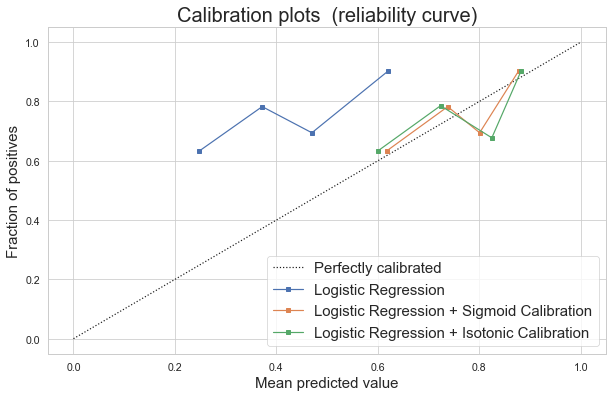

In [16]:
    
#figure_path = "NCDB_5_features/"
fig = plt.figure(figsize=(10, 6))
plt.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
fraction_of_positives, mean_predicted_value = calibration_curve(y_val, LR_y_val_probs, n_bins = 8)
plt.plot(mean_predicted_value, fraction_of_positives, "s-", label = "Logistic Regression")
fraction_of_positives, mean_predicted_value = calibration_curve(y_val, Sigmoid_y_val_probs, n_bins = 8)
plt.plot(mean_predicted_value, fraction_of_positives, "s-", label = "Logistic Regression + Sigmoid Calibration")
fraction_of_positives, mean_predicted_value = calibration_curve(y_val, Isotonic_y_val_probs, n_bins = 8)
plt.plot(mean_predicted_value, fraction_of_positives, "s-", label = "Logistic Regression + Isotonic Calibration")

plt.xlabel("Mean predicted value", size = 15)
plt.ylabel("Fraction of positives", size = 15)
plt.ylim([-0.05, 1.05])
plt.legend(loc="lower right", fontsize = 15)
plt.title('Calibration plots  (reliability curve)', size = 20)
plt.savefig(os.path.join(figure_path, "Calibration_validation_plot.png"))

### Results with regular model, default threshold 
- precision is identical because all patients being classified as no mets.

In [19]:
LR_y_val_probs = Isotonic.predict_proba(X_val)[:,1]
LR_y_val_pred = Isotonic.predict(X_val)
cm = confusion_matrix(y_val, LR_y_val_pred)
display(cm)
LR_val_scores = pd.DataFrame(get_scores(y_val, LR_y_val_pred))
display(LR_val_scores)

array([[  0,  62],
       [  0, 282]])

,metrics,scores
0,precision,0.819767
1,recall,1.000000
2,roc_auc,0.500000
3,accuracy,0.819767
4,f1 score,0.900958
5,pr_auc,0.819767
6,brier_score,0.180233


### Results with calibrated model, default threshold
- all patients are predicted for positive class.
- didn't change anything about the model performance!

In [20]:
Isotonic_y_val_probs = Isotonic.predict_proba(X_val)[:,1]
Isotonic_y_val_pred = Isotonic.predict(X_val)
cm = confusion_matrix(y_val, Isotonic_y_val_pred)
display(cm)
val_scores = pd.DataFrame(get_scores(y_val, Isotonic_y_val_pred))
display(val_scores)

array([[  0,  62],
       [  0, 282]])

,metrics,scores
0,precision,0.819767
1,recall,1.000000
2,roc_auc,0.500000
3,accuracy,0.819767
4,f1 score,0.900958
5,pr_auc,0.819767
6,brier_score,0.180233


### Results with calibrated model, adjust threshold

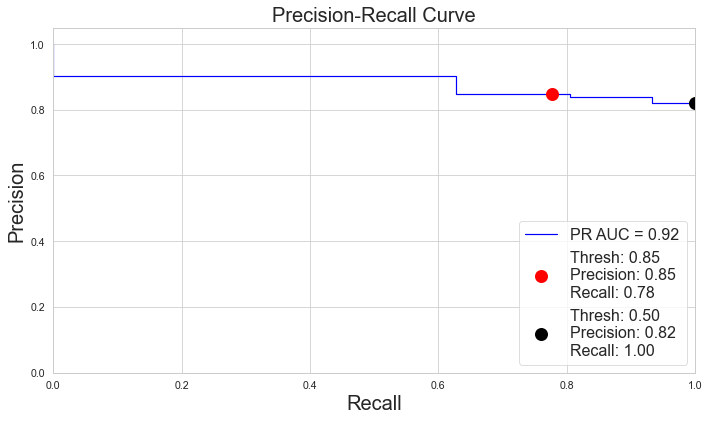

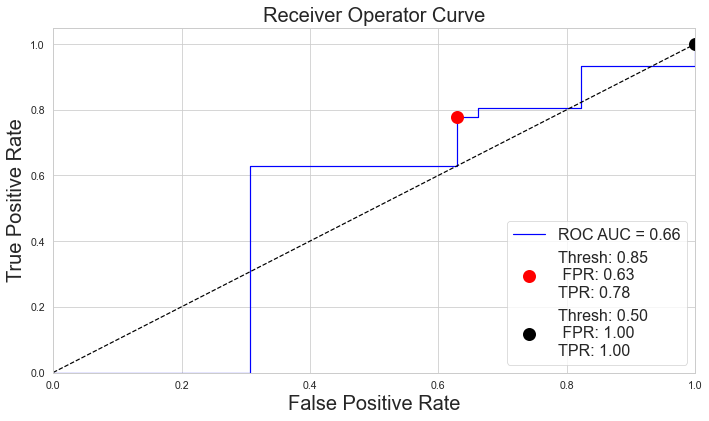

In [18]:
key_thresh = 0.85

custom_plots.plot_pr_curve(y_val, Isotonic_y_val_probs, key_thresh, 
                           filename = os.path.join(figure_path,"validation_PR_curve.png"))
custom_plots.plot_roc_curve(y_val, Isotonic_y_val_probs, key_thresh, 
                           filename = os.path.join(figure_path,"validation_ROC_curve.png"))

In [79]:

Isotonic_y_val_pred_adjusted =  Isotonic_y_val_probs > key_thresh
cm = confusion_matrix(y_val, Isotonic_y_val_pred_adjusted)
display(cm)
val_scores_adjusted = pd.DataFrame(get_scores(y_val, Isotonic_y_val_pred_adjusted))
display(val_scores_adjusted)

array([[ 43,  22],
       [108, 189]])

,metrics,scores
0,precision,0.895735
1,recall,0.636364
2,roc_auc,0.648951
3,accuracy,0.640884
4,f1 score,0.744094
5,pr_auc,0.868355
6,brier_score,0.359116


### Final model evaluation with logistic reg & isotonic calibration
- evaluate on hold out test set

In [74]:

Isotonic_y_test_probs = Isotonic.predict_proba(X_test)[:,1]
Isotonic_y_test_pred = Isotonic.predict(X_test)
Isotonic_y_test_pred_adjusted =  Isotonic_y_test_probs > key_thresh
Isotonic_scores = pd.DataFrame(get_scores(y_test, Isotonic_y_test_pred_adjusted))

Isotonic_scores.to_csv("../model_output/TNM_outcome/final_calibrated_logreg_test_scores.csv")
Isotonic_scores


,metrics,scores
0,precision,0.898361
1,recall,0.618510
2,roc_auc,0.649461
3,accuracy,0.629630
4,f1 score,0.732620
5,pr_auc,0.868608
6,brier_score,0.370370


../mcc_metastasis/modeling.py:70: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['']+['Mets', 'No Mets'])
../mcc_metastasis/modeling.py:71: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['']+['Mets', 'No Mets'])


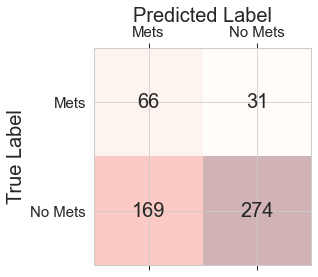

0.012396694214876033

In [75]:
cm = confusion_matrix(y_test, Isotonic_y_test_pred_adjusted)

modeling.pretty_cm(cm, os.path.join(figure_path, "Test_confusion_matrix_adjusted.png"))


### conclusions
- 1/3 of patients with metastasis would be miss-classified ... not good!